<a href="https://colab.research.google.com/github/higoress/gtsrb_gan/blob/master/GenerativeTrafficSigns_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Traffic Signs

We want to implement a Generative Adversarial Network to perform data augmentation on the German Traffic Signs Benchmark.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import urllib.request
import numpy as np
import zipfile
import os
import pickle
import PIL
import glob
import imageio
import time
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
print('Beginning file download...')

url = 'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip'

urllib.request.urlretrieve(url, './traffic-signs-data.zip')

Beginning file download...


('./traffic-signs-data.zip', <http.client.HTTPMessage at 0x7fe8267a75f8>)

In [ ]:
zip_ref = zipfile.ZipFile('./traffic-signs-data.zip', 'r')
zip_ref.extractall('./')
zip_ref.close()
#os.listdir("./")

In [ ]:
files = ['./train.p','./valid.p', './test.p']
train = []
for training_file in files:
  with open(training_file, mode='rb') as f:
    train.append(pickle.load(f))
train_images = np.concatenate([x['features'] for x in train])
train_labels = np.concatenate([y['labels']   for y in train])

In [ ]:
print(type(train_images))
print(train_images.shape)
print(type(train_labels))
print(train_labels.shape)

<class 'numpy.ndarray'>
(51839, 32, 32, 3)
<class 'numpy.ndarray'>
(51839,)


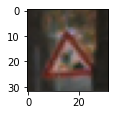

In [ ]:
indice = np.random.randint(0,len(train_images))
image = train_images[indice]
plt.figure(figsize=(1.5,1.5))
plt.imshow(image)

In [ ]:
train_images = train_images.astype('float32') / 255.0
#train_images = (train_images.astype('float32') - 127.5) / 127.5

In [ ]:
BUFFER_SIZE = 51839                                   #train_gi.shape[0]
BATCH_SIZE = 256

In [ ]:
#train_dataset = tf.data.Dataset.from_tensor_slices(train_gi).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Creating Models

In [ ]:
def create_generator_model():
  model = tf.keras.Sequential()
  dropout_prob = 0.4

  #acording to the paper, avoid dense layers

  n_nodes = 4*4*512

  model.add(layers.Dense(n_nodes, use_bias=False, input_shape=(250,))) 
 
  #model.add(layers.BatchNormalization())
  #model.add(layers.ReLU())
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Reshape((4,4,512)))
  #model.add(layers.Reshape((4,4,256)))
  
  model.add(layers.Conv2DTranspose(512, 5, strides=2, padding='same', use_bias=False))
  #model.add(layers.BatchNormalization())
  #model.add(layers.ReLU())
  
  
  model.add(layers.LeakyReLU(alpha=0.2))

  model.add(layers.Conv2DTranspose(256, 5, strides=2, padding='same', use_bias=False))
  #model.add(layers.BatchNormalization())
  #model.add(layers.ReLU())
  model.add(layers.LeakyReLU(alpha=0.2))

  model.add(layers.Conv2DTranspose(128, 5, strides=2, padding='same', use_bias=False))
  #model.add(layers.BatchNormalization())
  #model.add(layers.ReLU())
  #model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))

  #model.add(layers.Conv2DTranspose(3, 5, strides=1, padding='same', use_bias=False, activation='tanh'))
  model.add(layers.Conv2DTranspose(3, (3,3), padding='same', activation='tanh'))

  return model

In [ ]:
generator = create_generator_model()
generator.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 8192)              2048000   
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_28 (Conv2DT (None, 8, 8, 512)         6553600   
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_29 (Conv2DT (None, 16, 16, 256)       3276800   
_________________________________________________________________
leaky_re_lu_58 (LeakyReLU)   (None, 16, 16, 256)     

In [ ]:
generator.output_shape

(None, 32, 32, 3)

In [ ]:
def create_discriminator_model():
    model = tf.keras.Sequential()
    input_shape = (32, 32, 3)
    dropout_prob = 0.3

    model.add(layers.Conv2D(64, 5, strides=2, padding='same', input_shape=input_shape))
    #model.add(layers.Conv2D(64, (3,3), padding='same', input_shape=input_shape))
    #model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())
    model.add(layers.LeakyReLU(alpha=0.2))
    

    model.add(layers.Conv2D(128, 5, strides=2, padding='same'))
    #model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())
    
    #model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, 5, strides=2, padding='same'))
    #model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())

    #model.add(layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    
    model.add(layers.Conv2D(512, 5, strides=2, padding='same'))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4)) #
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = create_discriminator_model()
discriminator.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 2, 2, 512)       

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, 0.5)

In [ ]:
checkpoint_dir = '/content/gdrive/My Drive/Colab Notebooks/Gans/training/saved_models2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 50
noise_dim = 250
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      aux = np.squeeze(predictions[i])
      plt.imshow((aux * 255).astype(np.uint8))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

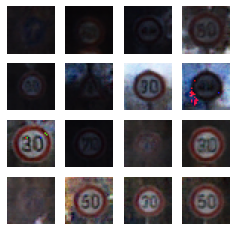

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
noise = tf.random.normal([num_examples_to_generate, 200])
generated_images = generator(noise, training=False)
for i in range(generated_images.shape[0]):
      plt.subplot(4, 4, i+1)
      aux = np.squeeze(generated_images[i])
      plt.imshow((aux * 255).astype(np.uint8))
      plt.axis('off')

InvalidArgumentError: ignored

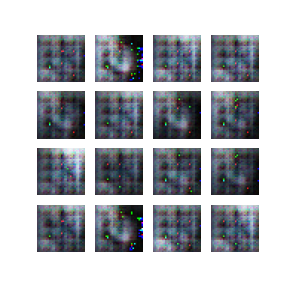

In [ ]:
display_image(1)

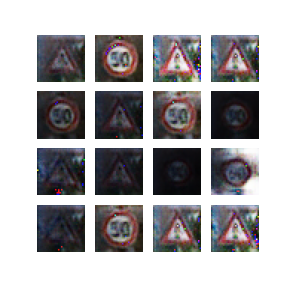

In [ ]:
display_image(10)